This is an implementation by Sebastian Raschka. As a practice exercise, I am trying to re-implement the algorithm. Link: https://sebastianraschka.com/Articles/2014_python_lda.html

# Linear Discriminant Analysis

Compute the dd-dimensional mean vectors for the different classes from the dataset.
Compute the scatter matrices (in-between-class and within-class scatter matrix).
Compute the eigenvectors (ee1,ee2,...,eedee1,ee2,...,eed) and corresponding eigenvalues (λλ1,λλ2,...,λλdλλ1,λλ2,...,λλd) for the scatter matrices.
Sort the eigenvectors by decreasing eigenvalues and choose kk eigenvectors with the largest eigenvalues to form a d×kd×k dimensional matrix WWWW (where every column represents an eigenvector).
Use this d×kd×k eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the matrix multiplication: YY=XX×WWYY=XX×WW (where XXXX is a n×dn×d-dimensional matrix representing the nn samples, and yyyy are the transformed n×kn×k-dimensional samples in the new subspace).

Dataset : http://archive.ics.uci.edu/ml/datasets/Wine

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

wineDf = pd.read_csv(
    filepath_or_buffer='http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header=None,
    sep=','
)


/Users/mathurtx/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
wineDf.columns = ['Label','Alcohol','Malic_acid','Ash','Alcalinity_of_ash','Magnesium','Total_phenols','Flavanoids','Nonflavanoid_phenols'
                  ,'Proanthocyanins','Color_intensity','Hue','OD280/OD315','Proline']
wineDf.head(5)

,Label,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
#Step 1: Computing the d-dimensional mean vectors

In [4]:
X = wineDf.ix[:,1:14].values
y = wineDf.ix[:,0].values

In [5]:
np.set_printoptions(precision=4)
mean_vectors_class = []
for label in range(1,4):
    mean_vectors_class.append(np.mean(X[y==label], axis=0))
    print('Mean Vector class %s: %s\n' %(label, mean_vectors_class[label-1])) 
    

Mean Vector class 1: [  1.3745e+01   2.0107e+00   2.4556e+00   1.7037e+01   1.0634e+02
   2.8402e+00   2.9824e+00   2.9000e-01   1.8993e+00   5.5283e+00
   1.0620e+00   3.1578e+00   1.1157e+03]

Mean Vector class 2: [  1.2279e+01   1.9327e+00   2.2448e+00   2.0238e+01   9.4549e+01
   2.2589e+00   2.0808e+00   3.6366e-01   1.6303e+00   3.0866e+00
   1.0563e+00   2.7854e+00   5.1951e+02]

Mean Vector class 3: [  1.3154e+01   3.3338e+00   2.4371e+00   2.1417e+01   9.9312e+01
   1.6788e+00   7.8146e-01   4.4750e-01   1.1535e+00   7.3962e+00
   6.8271e-01   1.6835e+00   6.2990e+02]



In [6]:
#Step 2: Computing the Scatter Matrices

In [7]:
Scatter_Matrix = np.zeros((X.shape[1], X.shape[1]))
for label, mv in zip(range(1,4), mean_vectors_class):
    class_scatter_matrix = np.zeros((X.shape[1], X.shape[1]))
    for row in X[y == label]:
        row, mv = row.reshape(X.shape[1],1), mv.reshape(X.shape[1],1)
        class_scatter_matrix+= (row - mv).dot((row - mv).T)
    Scatter_Matrix += class_scatter_matrix
print 'within-class Scatter Matrix:\n', Scatter_Matrix

within-class Scatter Matrix:
[[  4.5859e+01   1.4303e+00  -2.3291e+00  -1.7013e+01   3.1383e+00
    4.7422e+00   3.9605e+00  -1.7072e-01   2.9350e+00   4.3130e+01
    1.3687e-01  -8.7244e-01   2.1415e+03]
 [  1.4303e+00   1.5532e+02   3.7434e+00   7.2582e+01  -1.5563e+02
   -2.5349e+00  -1.6466e+00   1.7807e+00   3.0105e+00  -4.5273e+01
   -7.3732e+00   8.1426e+00  -5.7852e+03]
 [ -2.3291e+00   3.7434e+00   1.1563e+01   8.4728e+01   1.2067e+02
    2.8298e+00   5.2449e+00   1.2286e+00   4.6912e-01   1.7140e+00
    4.0639e-01   1.9095e+00  -8.7672e+01]
 [ -1.7013e+01   7.2582e+01   8.4728e+01   1.4012e+03   5.6662e+02
    1.9008e+01   4.3123e+01   8.2101e+00   1.6227e+01  -1.7814e+01
   -1.7204e+00   3.9486e+01  -5.7458e+03]
 [  3.1383e+00  -1.5563e+02   1.2067e+02   5.6662e+02   3.1615e+04
    1.0100e+02   1.1670e+02  -5.0235e+01   2.2757e+02   3.1017e+02
    2.2078e+01  -4.9198e+01   8.3344e+04]
 [  4.7422e+00  -2.5349e+00   2.8298e+00   1.9008e+01   1.0100e+02
    3.3472e+01   2.8229e

In [8]:
#Between-class scatter matrix SB
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((X.shape[1], X.shape[1]))
for i,mean_vec in enumerate(mean_vectors_class):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(X.shape[1],1) # make column vector
    overall_mean = overall_mean.reshape(X.shape[1],1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print 'between-class Scatter Matrix: \n', S_B

between-class Scatter Matrix: 
[[  7.0795e+01   1.3723e+01   1.0668e+01  -1.3186e+02   5.5262e+02
    2.1257e+01   3.0029e+01  -2.6178e+00   8.3076e+00   1.3888e+02
   -2.4933e+00   8.2530e+00   2.6987e+04]
 [  1.3723e+01   6.5578e+01   5.1556e+00   1.1793e+02   1.5062e+00
   -3.8943e+01  -7.9531e+01   5.4292e+00  -2.7994e+01   1.5941e+02
   -1.7995e+01  -5.9906e+01  -6.1709e+03]
 [  1.0668e+01   5.1556e+00   1.7592e+00  -1.2829e+01   7.8095e+01
    1.0900e+00   3.3671e-01  -1.0316e-01  -2.0087e-01   2.7430e+01
   -1.2351e+00  -1.7747e+00   3.5073e+03]
 [ -1.3186e+02   1.1793e+02  -1.2829e+01   5.7283e+02  -1.2702e+03
   -1.3780e+02  -2.5058e+02   1.8415e+01  -8.2987e+01   4.3483e+01
   -3.5293e+01  -1.5564e+02  -7.6268e+04]
 [  5.5262e+02   1.5062e+00   7.8095e+01  -1.2702e+03   4.4910e+03
    2.3822e+02   3.7768e+02  -3.0399e+01   1.1454e+02   8.6166e+02
    9.9330e+00   1.6767e+02   2.2980e+05]
 [  2.1257e+01  -3.8943e+01   1.0900e+00  -1.3780e+02   2.3822e+02
    3.5857e+01   6.743

In [9]:
eigen_values, eigen_vector = np.linalg.eig(np.linalg.inv(Scatter_Matrix).dot(S_B))
eigen_pairs = [(np.abs(eigen_values[i]), eigen_vector[:,i]) for i in range(len(eigen_values))]

In [10]:
eigen_pairs = sorted(eigen_pairs, key = lambda x: -x[0])

In [11]:
print 'Eigenvalues in decreasing order:\n'
for i in eigen_pairs:
    print(i[0])

Eigenvalues in decreasing order:

9.08173943504
4.12846904564
9.64715644323e-16
8.881784197e-16
7.45341003706e-16
7.45341003706e-16
6.91496825786e-16
6.91496825786e-16
3.2177919992e-16
2.83497860587e-16
2.83497860587e-16
1.46712361361e-16
3.26463714014e-17


In [12]:
eigen_total = sum(eigen_values)
var_exp = [(i / eigen_total)*100 for i in sorted(eigen_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

/Users/mathurtx/tensorflow/lib/python2.7/site-packages/matplotlib/patches.py:643: ComplexWarning: Casting complex values to real discards the imaginary part
  self._height = float(height)
/Users/mathurtx/tensorflow/lib/python2.7/site-packages/matplotlib/patches.py:641: ComplexWarning: Casting complex values to real discards the imaginary part
  self._y = float(xy[1])
/Users/mathurtx/tensorflow/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


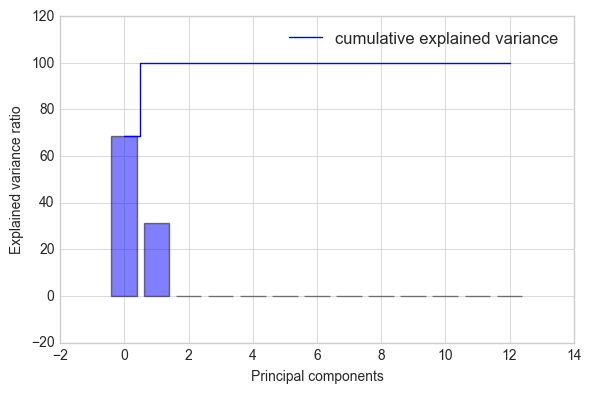

In [13]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(eigen_values)), var_exp, alpha=0.5, align='center')
    plt.step(range(len(eigen_values)), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [14]:
print('Variance explained:\n')
eigv_sum = sum(eigen_values)
for i,j in enumerate(eigen_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 68.75%
eigenvalue 2: 31.25%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%
eigenvalue 5: 0.00%
eigenvalue 6: 0.00%
eigenvalue 7: 0.00%
eigenvalue 8: 0.00%
eigenvalue 9: 0.00%
eigenvalue 10: 0.00%
eigenvalue 11: 0.00%
eigenvalue 12: 0.00%
eigenvalue 13: 0.00%


In [15]:
W = np.hstack((eigen_pairs[0][1].reshape(X.shape[1],1), eigen_pairs[1][1].reshape(X.shape[1],1)))
print('Matrix W:\n', W.real)

('Matrix W:\n', array([[ -1.4368e-01,  -2.5445e-01],
       [  5.8860e-02,  -8.9130e-02],
       [ -1.3146e-01,  -6.8467e-01],
       [  5.5136e-02,   4.2724e-02],
       [ -7.7060e-04,   1.3506e-04],
       [  2.2014e-01,   9.4018e-03],
       [ -5.9168e-01,   1.4360e-01],
       [ -5.3278e-01,   4.7602e-01],
       [  4.7761e-02,   8.9628e-02],
       [  1.2646e-01,  -7.3909e-02],
       [ -2.9137e-01,   4.4236e-01],
       [ -4.1230e-01,  -1.4939e-02],
       [ -9.5856e-04,  -8.3269e-04]]))


In [16]:
#Transformed Matrix
Y = X.dot(W)

/Users/mathurtx/tensorflow/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


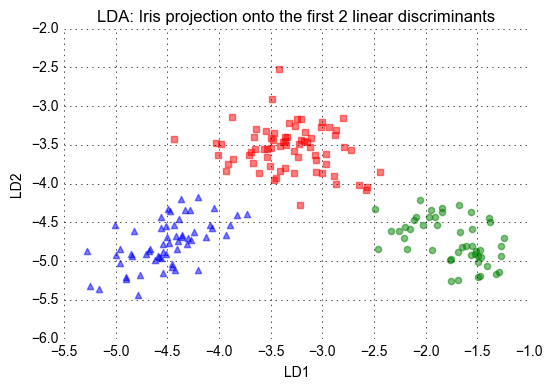

In [17]:
from matplotlib import pyplot as plt

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=Y[:,0].real[y == label],
                y=Y[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    plt.title('LDA: Wine projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()